# Lab 2: So where do all those reference genomes come from anyway? (Sequence assembly)

## Part 1 (40 pts)

Reminder, you can work with your classmates! And feel free to use the internet to help you.

Skills covered: genome size estimation, sequence assembly, command line one-liners, managing computational resources

### Intro

Today, you will explore using kmer count histograms to estimate the size of a sequenced *E. coli* strain and compare your result to existing software packages for performing this task. In the next session, you will assemble the sequencing reads into a (semi) complete genome and evaluate the quality of the resulting sequence.

Today we will focus on an Illumina whole genome sequencing dataset from an *E. coli* sample. The dataset has paired-end reads with an average insert size of 215.4 bp (+/- 10.6bp). Reads are 100bp each.

Fastq files can be found in the `lab2` directory:
```shell
ls ~/public/lab2
```

You should see `shortfrag_1.fq`, `shortfrag_2.fq`, which are the files we will use today. There is an additional fastq file in that directory that we'll be looking at next lab session.

## 1. Inspecting reads with fasqtc

First, open up a terminal and create a `lab2` directory in your home directory. `cd` into and work out of there for today.

**Question 1 (2 pts)**: Recall from lab 1 how we used the `fastqc` tool to examine the quality of our reads as a preprocesing step. Apply `fastqc` to the two fastq files from the "shortfrag" dataset. Set the python string `q1_cmd` below to the exact command(s) you used to do so.

In [2]:
q1_cmd = """
Paste your fastqc command here!
"""
# your code here
q1_cmd = "fastqc -o . ~/public/lab2/shortfrag_1.fq ~/public/lab2/shortfrag_2.fq"

# raise NotImplementedError

In [3]:
""" Check the fastqc command is reasonable"""
assert("shortfrag_1.fq" in q1_cmd)
assert("shortfrag_2.fq" in q1_cmd)
# Hidden tests perform additional basic checks

**Question 2 (2 pts)**: Do you see any concerning things (red X's) in the fastqc output? Which of the following sections is marked as problematic? Set the variable `q2_answer` to your answer below.

* A. Per-base GC content
* B. Per-base sequence quality
* C. Sequence length distribution
* D. Kmer content

In [4]:
q2_answer = "" # Set to your answer fo question 2 above ("A", "B", "C", or "D")
# your code here
q2_answer = "B"
# raise NotImplementedError

In [5]:
""" Check the answer is valid"""
assert(q2_answer in ["A", "B", "C", "D"])
# Hidden tests check the actual answer

## 2. Trimming reads for quality control

Before we move forward with genome size estimation, let's try to address the quality control issues flagged by `fastqc`. We'll be using a new tool to help with this.

`sickle` is a tool for trimming low quality ends of reads. It uses a sliding window trimming algorithm, where a small window slides along the sequence, starting from one end, cutting off sequence until the average quality is above a user specified threshold, then the window keeps going until the average quality drops below that threshold, and cuts off any sequence past that point.

First, to learn about `sickle`, type `sickle pe` at the command line.

You can specify both the quality threshold and a length threshold, which will discard any sequences that are shorter than a certain length after trimming. The defaults for both of these values are 20. Run sickle on your data with the default settings, remembering to specify the full paths to the fastq files in the public folder. Below is an example command.

```shell
sickle pe \
    -f file_1.fq \
    -r file_2.fq \
    -t sanger \
    -o ~/lab2/shortfrag_trimmed_1.fq \
    -p ~/lab2/shortfrag_trimmed_2.fq \
    -s ~/lab2/shortfrag_singletons.fq
```

Note this command should all be on one line. To make it more readable it is broken up into multiple lines. A `\` means the command is continued on the next line. Note the paths given above are not real and are just meant as examples. 

You’ll notice that there are 3 output files (`-o`, `-p`, and `-s`). The first two are the trimmed forward and reverse reads, where BOTH the forward and its matching reverse read passed the trimming filter. The singletons file contains reads where one read passed the trimming filter, but its partner did not. The reads that do not pass are not output.

**Question 3 (5 pts):** Run `sickle pe` to trim the `shortfrag` library using default parameters. Be sure to write the output files (`-o`, `-p`, and `-s` files) to your `~/lab2` directory. Set the variable `q3_cmd` to the exact command you used.

Your command should create output files:
* `~/lab2/shortfrag_trimmed_1.fq` (~2.8G)
* `~/lab2/shortfrag_trimmed_2.fq` (~2.7G)
* `~/lab2/shortfrag_singletons.fq` (64M)

This will take a couple minutes. You can go on to the next part while you wait.

<blockquote>
**UNIX TIP**: If a command is taking a long time to run, and you want to close your computer, you can use `nohup` to run it in the background. See example below:
</blockquote>

```shell
nohup sickle pe .... &
```
This will write the output that would have printed to the screen to nohup.out. You can use `ls -ltrh` in the output directory to make sure the file sizes keep growing. The command should finish when the output files get to the sizes listed above.

In [6]:
q3_cmd = """
Paste your sickle command here!
"""
# your code here
q3_cmd = """
sickle pe -f ~/public/lab2/shortfrag_1.fq  -r ~/public/lab2/shortfrag_2.fq -t illumina -o ~/lab2/shortfrag_trimmed_1.fq -p ~/lab2/shortfrag_trimmed_2.fq -s ~/lab2/shortfrag_singletons.fq
"""
# raise NotImplementedError

In [7]:
"""Basic checks on the command"""
assert("sickle" in q3_cmd)
assert("pe" in q3_cmd)
# Hidden tests perform additional checks

In [8]:
""" Additional hidden tests"""

' Additional hidden tests'

In [9]:
""" Additional hidden tests"""

' Additional hidden tests'

**Question 4 (3 pts):** Rerun `fastqc` on the trimmed dataset. Set `q4_cmd` below to the command you used to run `fastqc` on the trimmed data.

You should see that all fastqc issues are resolved after trimming. If not, ask a TA or friend before moving on to the next steps!

In [10]:
q4_cmd = """
Paste your new fastqc command here!
"""
# your code here
q4_cmd =  "fastqc -o . ~/lab2/shortfrag_trimmed_1.fq ~/lab2/shortfrag_trimmed_2.fq"

# raise NotImplementedError

In [11]:
"""Basic checks on the command"""
assert("fastqc" in q4_cmd)
assert(q4_cmd != q1_cmd)

## 3. Generating and visualizing the kmer distribution

We'll use the trimmed "shortfrag" dataset to first count k-mers in our data to generate kmer count distributions similar to in the exercises. For this purpose it's ok to only analyze the forward fragment (your trimmed version of `shortfrag_1.fq`).

**Jellyfish** is a kmer counting program that will count the frequency of all possible k-mers of a given length in our data.

We will use two subcommands. `jellyfish count` counts kmers and creates a hash table. 

* `-m` specifies the kmer length
* `-C` tells it to ignore directionality (it treats each read the same as its reverse complement)
* `-s` is an initial estimate for the size of the hash table jellyfish uses. Let's set to 100M (100 million).
* `-o` specifies the name of the output file.

`jellyfish histo` computes a histogram of kmer count occurrences. You can use the two tools to create a histogram file. e.g.:

```shell
jellyfish count -m 18 -C -s 100M -o output.jf input.fq
jellyish histo output.jf > output.histo
```

Note the `>` symbol means put the output of the previous command into the specified file. If you don't use `>` it will output the results to standard output (your terminal screen).

**Question 5 (3 pts):** Run `jellyfish count` on the trimmed `shortfrag_1.fq` file using a kmer size of 18. Then use `jellyfish histo` to create a histogram file. Set the variable `q5_cmds` below to the commands you used. Your commands might take a couple minutes to run.

In [12]:
q5_cmd = """
Paste your jellyfish commands here!
"""

# your code here
q5_cmd = """
jellyfish count -m 18 -C -s 100M -o output.jf ~/lab2/shortfrag_trimmed_1.fq
jellyfish histo output.jf > shortfrag.histo
"""

# raise NotImplementedError

In [13]:
"""Basic checks on the command"""
assert(q5_cmd.count("jellyfish")==2)
# Hidden tests perform additional checks

In [14]:
"""Basic checks on the command"""
assert("histo" in q5_cmd)
# Hidden tests perform additional checks

You can inspect the histogram output using the UNIX `cat` command, which we saw last week:

```shell
cat shortfrag.histo
```

You should see two columns: the first gives the number of times a kmer was seen. The second gives the number of kmers seen that many times. So, for example, the first line gives the number of kmers seen exactly once. 

**Question 6 (5 pts):** Complete the function `GetKmerHistogram` below to read in the histo file, compute a histogram of kmer counts, and and plot the histogram. (The x-axis represents column 1 in the `.histo` file, or number of occurrences, and the y-axis is given by column 2, or number of kmers.) Hint: you should see a big spike at 1 and a bell curve further to the right. You might want to play with the variables `max_xval` and `max_yval` to make your visualization more informative by zooming in on the most important region. Without setting those you might have some pretty extreme x- and y-value data points dominating your plot. We have set them to reasonable starting points.

As we did last week, please copy the histogram file to the directory of this notebook to make sure the grader will find it.

Populating the interactive namespace from numpy and matplotlib


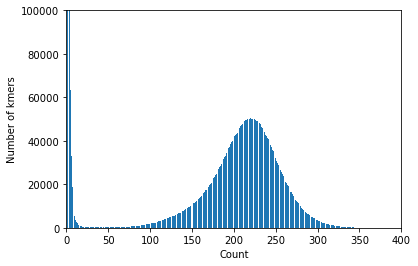

In [15]:
%pylab inline
import os

assert("shortfrag.histo" in os.listdir("."))

def GetKmerHistogram(histofile, max_xval=None, max_yval=None, plot=True):
    """ Plot a histogram of the kmer counts
    
    Parameters
    ----------
    histofile : str
       Path to a histogram file from jellyfish and 
    max_xval : int
       Maximum x-axis value. If set to None, use the full data range
    max_yval : int
       Maximum y-axis value. If set to None, use the full data range
    plot : bool
       If set to False, do not output the plot.
    Returns
    -------
    kmer_counts : dict[int]->int. Key=kmer count. Value=number of kmers
       seen that many times
    """
    kmer_counts = {} # Dictionary of count -> number of kmers
    # Read the histofile
    # Use its contents to update kmer_counts
    # your code here
    
    with open(histofile, 'r') as file:
        for line in file:
            count, num_kmers = map(int, line.strip().split())
            kmer_counts[count] = num_kmers
#     raise NotImplementedError
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.bar(kmer_counts.keys(), kmer_counts.values())
        ax.set_xlabel("Count")
        ax.set_ylabel("Number of kmers")
        if max_xval is not None: ax.set_xlim(left=0, right=max_xval)
        if max_yval is not None: ax.set_ylim(bottom=0, top=max_yval)
    return kmer_counts

kmer_counts = GetKmerHistogram("shortfrag.histo", max_xval=400, max_yval=100000)

In [16]:
"""Basic checks on PlotKmerHistogram output"""
kmer_counts = GetKmerHistogram("shortfrag.histo", plot=False)
assert(len(kmer_counts.keys())>2000 and len(kmer_counts.keys()) < 3000)
assert(abs(kmer_counts[1]>kmer_counts[2]))
assert(kmer_counts[1]/kmer_counts[500]>200000)

In [17]:
"""Additional tests on PlotKmerHistogram output"""

'Additional tests on PlotKmerHistogram output'

## 4. Estimating genome size from the kmer distribution

Now we will use the kmer distribution to estimate the size of the genome of our E. coli strain. Look back to the exercises to see how we derived the formula for genome size:

$$ G \approx \frac{\texttt{Total num. kmers observed}}{\texttt{Kmer coverage (M)}} $$

**Question 7 (2 pts):** First, let's figure out $M$, the average kmer coverage. Recall this is the point where our kmer histogram peaks (ignoring the big spike of error kmers on the left). Figure out the peak by eyeballing the histogram and set the variable `q7_estimate` to your answer for $M$ below.

In [18]:
q7_estimate = -1 # Set to your estimate for M based on eyeballing the plot

# your code here
q7_estimate = 225
# raise NotImplementedError

In [19]:
"""Basic checks on q7_estimate"""
assert(type(q7_estimate)==int)
assert(q7_estimate > 0 and q7_estimate < 400)
assert(kmer_counts[q7_estimate]>kmer_counts[50] and kmer_counts[q7_estimate]>kmer_counts[300])

**Question 8 (3 pts):** Now complete the functions `EstimateValley` and `EstimateM` below to get a precise estimate of the first valley and peak location after removing errorenous kmers. The first valley is the point where kmer counts start increasing. The peak location ($M$) is the maximum point after the first valley. Make sure your answers look reasonably close to what you what have guessed from just looking at the plot. We'll accept a range of answers.

In [20]:
# Check the histogram file is here
assert("shortfrag.histo" in os.listdir("."))

def EstimateValley(kmer_counts):
    """ Estimate the valley position
    
    Parameters
    ----------
    kmer_counts : dict[int]->int. Key=kmer count. Value=number of kmers
       seen that many times
       
    Returns
    -------
    valley : int
       Position of the valley (position where kmer counts stop going down)
    """
    valley = 0
    # your code here
    prev_count = float('inf')
    for count in sorted(kmer_counts.keys()):
        if count > 1 and kmer_counts[count] > prev_count:
            valley = count - 1
            break
        prev_count = kmer_counts[count]
#     raise NotImplementedError
    return valley

def EstimateM(kmer_counts, valley_point):
    """ Estimate the peak M (mean kmer coverage)
    
    Parameters
    ----------    
    kmer_counts : dict[int]->int. Key=kmer count. Value=number of kmers
       seen that many times
    valley_point : int
       Position of the valley (position where kmer counts stop going down)

    Returns
    -------
    est_m : int
       Estimated peak in the kmer plot
    """
    est_m = 0
    # your code here
    
    max_count = 0
    for count in sorted(kmer_counts.keys()):
        if count > valley_point and kmer_counts[count] > max_count:
            max_count = kmer_counts[count]
            est_m = count
#     raise NotImplementedError
    return est_m

histofile = "shortfrag.histo"
kmer_counts = GetKmerHistogram("shortfrag.histo", plot=False)
est_valley = EstimateValley(kmer_counts)
est_m = EstimateM(kmer_counts, est_valley)

print("Estimated valley point: " + str(est_valley))
print("Estimated M: " + str(est_m))

Estimated valley point: 24
Estimated M: 220


In [21]:
"""Check EstimateValley"""
histofile = "shortfrag.histo"
kmer_counts = GetKmerHistogram("shortfrag.histo", plot=False)
est_valley = EstimateValley(kmer_counts)
assert(est_valley>10 and est_valley<50)

"""Check EstimateM"""
est_m = EstimateM(kmer_counts, est_valley)
assert(est_m>200 and est_m<250)

Now we'll estimate the total number of kmers seen. We will want to ignore kmers that are likely due to errors. Look at your histogram and estimate where the first "valley" is. After this point we can assume kmers seen more than that many times are not due to errors. We can estimate the total number of non-error kmers observed to the right of the first valley point. Keep in mind that for an example data point (count, num kmers), each of those kmers was seen **count** number of times. So you'll want to keep track of 50 * the number of kmers seen 50 times, plus 51 * the number of kmers seen 51 times, etc.

**Question 9 (4 pts):** Complete the function `EstimateNumKmersSeen` below to output an estimate of the number of observed kmers.

In [22]:
def EstimateNumKmersSeen(kmer_counts, valley_point):
    """ Estimate the total number of kmers seen
    
    Parameters
    ----------
    kmer_counts : dict[int]->int. Key=kmer count. Value=number of kmers
       seen that many times
    valley_point : int
       Position of the valley (position where kmer counts stop going down)

    Returns
    -------
    num_total_kmers : int
       Total number of kmers seen
    """
    num_total_kmers = 0
    # your code here
    for count in sorted(kmer_counts.keys()):
        if count > valley_point:
            num_total_kmers += count * kmer_counts[count]
#     raise NotImplementedError
    return num_total_kmers

histofile = "shortfrag.histo"
kmer_counts = GetKmerHistogram("shortfrag.histo", plot=False)
est_valley = EstimateValley(kmer_counts)
num_total_kmers = EstimateNumKmersSeen(kmer_counts, est_valley)
num_total_kmers

990648789

In [23]:
"""Check EstimateNumKmersSeen"""
histofile = "shortfrag.histo"
kmer_counts = GetKmerHistogram("shortfrag.histo", plot=False)
est_valley = EstimateValley(kmer_counts)
num_total_kmers = EstimateNumKmersSeen(kmer_counts, est_valley)
assert(num_total_kmers > 900000000 and num_total_kmers < 1000000000)

**Question 10: (1 pt)** Finally, use your estimates for the total number of kmers seen and for $M$ to estimate the E. coli genome size. Set the variable `q10_answer` to your answer below. (You should hopefully get something between 4-5 million bp).

In [24]:
q10_answer = 0 # Set to the estimated genome size

# your code here
# print(990648789/220)
q10_answer = num_total_kmers/220
q10_answer
# raise NotImplementedError

4502949.040909091

In [25]:
"""Basic checks on estaimted genome size"""
assert(q10_answer > 4000000 and q10_answer < 5000000)
# Additional hidden tests make sure this was computed based
# on your answers to num_total_kmers and est_m

## 5. Estimating genome size using kmergenie

Now, we'll check our answer by comparing to a tool, **kmergenie**, written to estimate genome sizes from an input set of reads. The tool takes as input a fastq file and outputs several files. We're most interested in `histograms_report.html` that gives a report of the results. Type `kmergenie` to see the usage for this tool.

For the best results, we can give it all of our fastq files. `kmergenie` can take in a file with a list of fastq file paths. To make such a file and run `kmergenie` you can do:

```shell
ls shortfrag*.fq > readfiles
```

This lists all the files matching these patterns then writes them (remember the `>` symbol) to the file `readfiles`.

**Question 11 (4 pts):** Run `kmergenie` on our fastq files. 
* Set the variable `q11_cmds` to the commands you used for this. 
* Look at the html output it produced (`histograms_report.html`). What did it find to be the best value for $k$? Set the variable `q11_bestk` below to your answer.
* What did it predict the genome (assembly) size to be? Set `q11_size` below to your answer.

Is your answer for `q11_size` close to your answer to question 10 above? (It should be! If not something went wrong.)

In [26]:
q11_cmds = """
# Paste your kmergenie commands here!
"""
q11_bestk = 0 # set to the best k estimated by kmergenie
q11_size = 0 # set to the genome size estimated by kmergenie

# your code here
q11_cmds = """
ls shortfrag*.fq > readfiles
kmergenie readfiles
"""
q11_bestk = 81 # set to the best k estimated by kmergenie
q11_size = 4577109 # set to the genome size estimated by kmergenie


# raise NotImplementedError

In [27]:
"""Basic checks on q11_cmds"""
assert("kmergenie" in q11_cmds)

In [28]:
"""Basic checks on q11_k"""
assert(q11_bestk in [21, 31, 41, 51, 61, 71, 81, 91])
# Additional hidden checks

In [29]:
"""Basic checks on q11_size"""
assert(type(q11_size)==int)
assert(q11_size>4000000 and q11_size<5000000)

## 6. Additional exercises

**Question 12 (2 pts)**: Look up the reference assembly info for this E. coli strain https://www.ncbi.nlm.nih.gov/nuccore/NC_000913.3. What is the reported genome size? Set `q12_answer` below to your answer.

Is your answer close to our estimate above? If not something went wrong!

In [30]:
q12_answer = -1 # Set to the size of NC_000913.3
# your code here

q12_answer =4641652
# raise NotImplementedError

In [31]:
"""Basic check on q12_answer"""
assert(type(q12_answer)==int)
assert(q12_answer > 4000000 and q12_answer < 5000000)
# Hidden tests check actual answer

**Question 13 (2 pts)** So far we have considered kmer histograms for a *haploid* organism (E. coli) which only has one copy of the genome. However many organisms (e.g. humans!) we will deal with are *diploid*, meaning they have two copies of the genome, which could have genetic variation from each other. For instance, if you have a heterozygous SNP, then kmers overlapping each of the two alleles will be different.

How do you expect the kmer distribution to change for a diploid genome? Choose from the following answers and set `q13_answer` to your answer below.

* A: There will be two bell-shaped curves. The farthest right will represent kmers without any genetic variation. The farthest left will represent kmers from regions of the genome that have variation between the two copies.
* B: There will be a single bell-shaped curve, but the estimated value for $M$ will be twice as big since each kmer is seen twice as many times.
* C: The kmer distribution will have a longer tail, i.e. there will be an excess of kmers seen a large number of times.

In [32]:
q13_answer = None # Choose from the options above
# your code here
q13_answer ="A"
# raise NotImplementedError

In [33]:
"""Basic check on q13_answer"""
assert(q13_answer in ["A","B","C"])
# Hidden tests check actual answer

**Question 14 (2 pts)**: What will the kmer count distribution look like for a genome sequenced to very low coverage? e.g. $<$5x? Choose from the following answers and set `q14_answer` to your answer below.

* A: There will be an excess of kmers with large kmer counts
* B: The peak ($M$) will be indistinguishable from the spike of error kmers at the left hand side of the graph
* C: The peak ($M$) will be higher since there will be more total kmers observed.

In [34]:
q14_answer = None # Choose from the options above
# your code here
q14_answer = "B"
# raise NotImplementedError

In [35]:
"""Basic check on q13_answer"""
assert(q14_answer in ["A","B","C"])
# Hidden tests check actual answer